##### Copyright 2020 Google

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Data analysis

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/guide/data_analysis"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/guide/data_analysis.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/guide/data_analysis.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/guide/data_analysis.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This is the follow up to the [data collection](data_collection.ipynb) tutorial. We have measured bitstrings for the single-qubit circuit $R_y(\theta)$ for various `theta`s. In this analysis, we compute $\langle Z \rangle (\theta)$, compare to the analytically expected true value, and fit to a depolarizing noise model with T1 decay during readout.

## Setup

Install the ReCirq package:

In [2]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


Now import Cirq, ReCirq and the module dependencies:

In [3]:
import cirq
import recirq

from recirq.readout_scan.tasks import EXPERIMENT_NAME, DEFAULT_BASE_DIR

## Load data

We can use utilities in ReCirq to query the filesystem and load in a dataset. Please recall that all tasks have an associated `EXPERIMENT_NAME` and a `dataset_id` which define the top two hierarchies in the filesystem. We import these values from the data collection script to ensure consistency.

If you're running this notebook in Colab or you haven't yet gone through the Data Collection tutorial, we will download a pre-generated copy of the data for analysis.

In [4]:
recirq.fetch_guide_data_collection_data()

`recirq.iterload_records` uses these two bits of information to iterate over records saved using `recirq.save` (in the data collection script.

This also gives you a chance to do post-processing on the data. In general, you should do some massaging of the data and put the results into a pandas DataFrame. DataFrames are great for doing statistics and visualizations across tabular data.

In [5]:
import numpy as np
import pandas as pd

records = []
# Load all data, do some light processing
for record in recirq.iterload_records(dataset_id='2020-02-tutorial', base_dir=DEFAULT_BASE_DIR):
    # Expand task dataclass into columns
    recirq.flatten_dataclass_into_record(record, 'task')
    
    # Unwrap BitArray into np.ndarray
    all_bitstrings = [ba.bits for ba in record['all_bitstrings']]
    
    # Compute <Z>
    record['z_vals'] = [np.mean((-1)**bitstrings, axis=0).item() for bitstrings in all_bitstrings]
    
    # Don't need to carry around the full array of bits anymore
    del record['all_bitstrings']
    records.append(record)
    
df = pd.DataFrame(records)
print(len(df))
df.head()

5


timestamp  \
0  2020-08-31T12:05:34.236188   
1  2020-08-31T12:05:36.742619   
2  2020-08-31T12:05:39.501528   
3  2020-08-31T12:05:42.138888   
4  2020-08-31T12:05:44.670296   

                                              thetas        dataset_id  \
0  [-1.5707963267948966, -1.3089969389957472, -1....  2020-02-tutorial   
1  [-1.5707963267948966, -1.3089969389957472, -1....  2020-02-tutorial   
2  [-1.5707963267948966, -1.3089969389957472, -1....  2020-02-tutorial   
3  [-1.5707963267948966, -1.3089969389957472, -1....  2020-02-tutorial   
4  [-1.5707963267948966, -1.3089969389957472, -1....  2020-02-tutorial   

       device_name  n_shots    qubit  resolution_factor  \
0  Syc23-simulator    40000  q(3, 2)                  6   
1  Syc23-simulator    40000  q(4, 1)                  6   
2  Syc23-simulator    40000  q(4, 2)                  6   
3  Syc23-simulator    40000  q(4, 3)                  6   
4  Syc23-simulator    40000  q(5, 0)                  6   

                                              z_vals  
0  [0.00065, 0.2531, 0.49645, 0.70395, 0.8568, 0....  
1  [0.00355, 0.24805, 0.49835, 0.7069, 0.86295, 0...  
2  [-0.00295, 0.2643, 0.50235, 0.70395, 0.8566, 0...  
3  [-0.00815, 0.25195, 0.4943, 0.70735, 0.85875, ...  
4  [0.0077, 0.2555, 0.49365, 0.6971, 0.8576, 0.96...

## Plot the data

A good first step.

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

entry = df.iloc[0] # Pick the first qubit

plt.plot([], []) # advance color cycle in anticipation of future analysis
plt.plot(entry['thetas'], entry['z_vals'], 'o-')
plt.xlabel('Theta', fontsize=14)
plt.ylabel(r'$\langle Z \rangle$', fontsize=14)
plt.title("Qubit {}".format(entry['qubit']), fontsize=14)
plt.tight_layout()

## How does it compare to analytical results?

You could imagine setting up a separate task for computing and saving analytic results. For this single qubit example, we'll just compute it on the fly.

In [7]:
qubit = cirq.LineQubit(0)
thetas = df.iloc[0]['thetas']

class _DummyMeasurementGate(cirq.IdentityGate):
    """A dummy measurement used to trick simulators into applying
    readout error when using PauliString.expectation_from_xxx."""

    def _measurement_key_(self):
        return 'dummy!'

    def __repr__(self):
        if self.num_qubits() == 1:
            return '_DummyMeasurementGate'
        return '_DummyMeasurementGate({!r})'.format(self.num_qubits())

    def __str__(self):
        if (self.num_qubits() == 1):
            return 'dummyM'
        else:
            return 'dummyM({})'.format(self.num_qubits())

    def _circuit_diagram_info_(self, args):
        from cirq import protocols
        return protocols.CircuitDiagramInfo(
            wire_symbols=('dM',) * self.num_qubits(), connected=True)

def dummy_measure(qubits):
    return _DummyMeasurementGate(num_qubits=len(qubits)).on(*qubits)

def get_circuit(theta):
    return cirq.Circuit([
        cirq.ry(theta).on(qubit),
        dummy_measure([qubit])
    ])

true_z_vals = []
for theta in thetas:
    wf = cirq.final_state_vector(get_circuit(theta))
    op = cirq.Z(qubit) * 1.
    true_z_val = op.expectation_from_state_vector(wf, qubit_map={qubit:0}, check_preconditions=False)
    true_z_vals.append(np.real_if_close(true_z_val).item())

true_z_vals = np.array(true_z_vals)
true_z_vals

array([ 0.        ,  0.25881901,  0.5       ,  0.70710677,  0.86602539,
        0.96592587,  1.        ,  0.96592587,  0.86602539,  0.70710677,
        0.5       ,  0.25881901,  0.        , -0.25881901, -0.5       ,
       -0.70710677, -0.86602539, -0.96592587, -1.        , -0.96592587,
       -0.86602539, -0.70710677, -0.5       , -0.25881901,  0.        ])

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(thetas, true_z_vals, '-', label='True')
ax1.plot(entry['thetas'], entry['z_vals'], 'o-', label='Data')

ax2.plot([], []) # advance color cycle
ax2.plot(entry['thetas'], np.abs(true_z_vals - entry['z_vals']), 'o-', label='|Data - True|')

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
ax1.set_xlabel('Theta', fontsize=14)
ax2.set_xlabel('Theta', fontsize=14)

fig.tight_layout()

## Learn a model

Our experimental data has some wiggles in it, but it also has a clear pattern of deviation from the true values. We can hypothesize a (parameterized) noise model and then use function minimization to fit the noise model parameters.

In [9]:
import scipy.optimize
import cirq.contrib.noise_models as ccn

def get_obj_func(data_expectations):
    all_results = []
    def obj_func(x):
        depol_prob, decay_prob, readout_prob = x
        
        if depol_prob < 0 or decay_prob < 0 or readout_prob < 0:
            # emulate constraints by returning a high cost if we
            # stray into invalid territory
            return 1000

        sim = cirq.DensityMatrixSimulator(
            noise=ccn.DepolarizingWithDampedReadoutNoiseModel(
                depol_prob=depol_prob, decay_prob=decay_prob, bitflip_prob=readout_prob))
        
        results = []
        for theta in thetas:            
            density_result = sim.simulate(get_circuit(theta))
            op = cirq.Z(qubit) * 1.
            true_z_val = op.expectation_from_state_vector(
                density_result.final_density_matrix, 
                qubit_map=density_result.qubit_map, check_preconditions=False)
            results.append(np.real_if_close(true_z_val).item())

        results = np.array(results)
        all_results.append(results)
        cost = np.sum(np.abs(results - data_expectations))
        return cost
    
    return obj_func, all_results

In [10]:
def print_result(x):
        depol_prob, decay_prob, readout_prob = x
        print(f'depol   = {depol_prob:.2%}')
        print(f'decay   = {decay_prob:.2%}')
        print(f'readout = {readout_prob:.2%}')

In [11]:
dfb = df
dfb = dfb.head(5) # Remove this to do all qubits
len(dfb)

5

Optimization terminated successfully.
         Current function value: 0.046614
         Iterations: 24
         Function evaluations: 46
Qubit 3, 2
depol   = 0.28%
decay   = 1.18%
readout = 1.14%


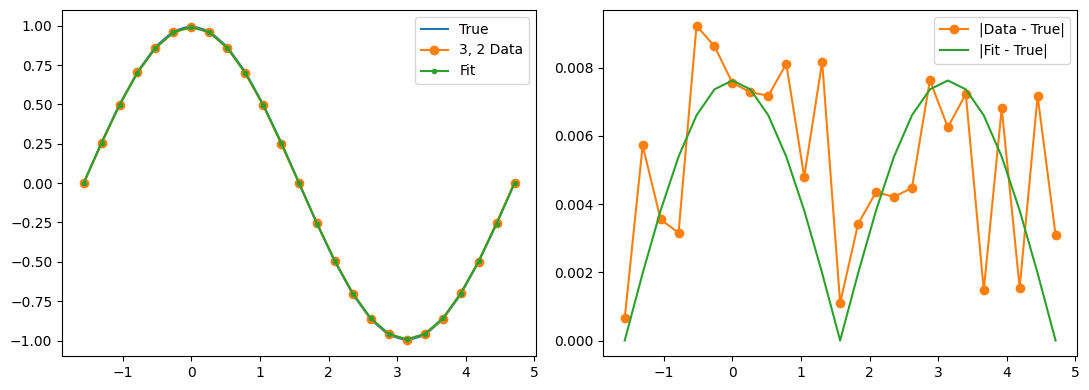

Optimization terminated successfully.
         Current function value: 0.074939
         Iterations: 22
         Function evaluations: 44
Qubit 4, 1
depol   = 0.25%
decay   = 1.20%
readout = 1.14%


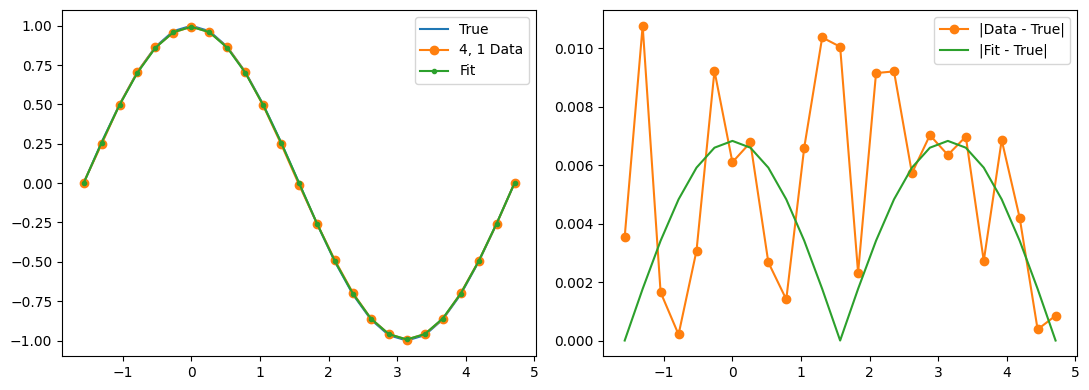

Optimization terminated successfully.
         Current function value: 0.071050
         Iterations: 26
         Function evaluations: 50
Qubit 4, 2
depol   = 0.27%
decay   = 1.18%
readout = 1.15%


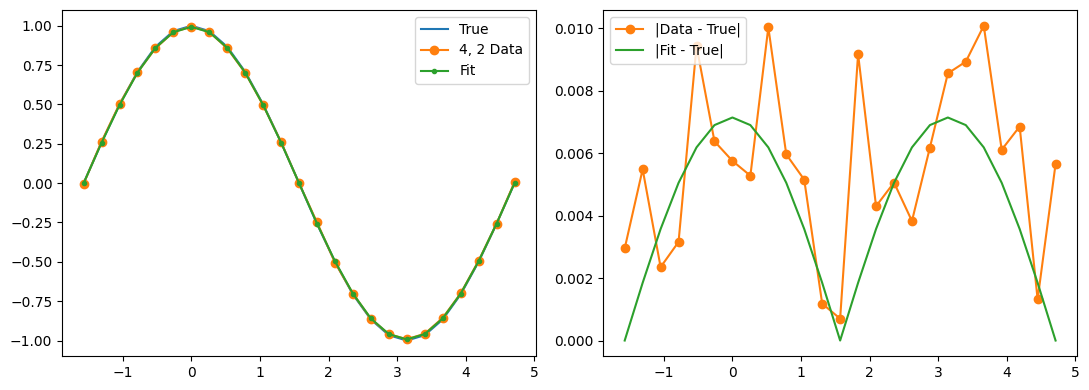

Optimization terminated successfully.
         Current function value: 0.061544
         Iterations: 32
         Function evaluations: 61
Qubit 4, 3
depol   = 0.22%
decay   = 1.23%
readout = 1.13%


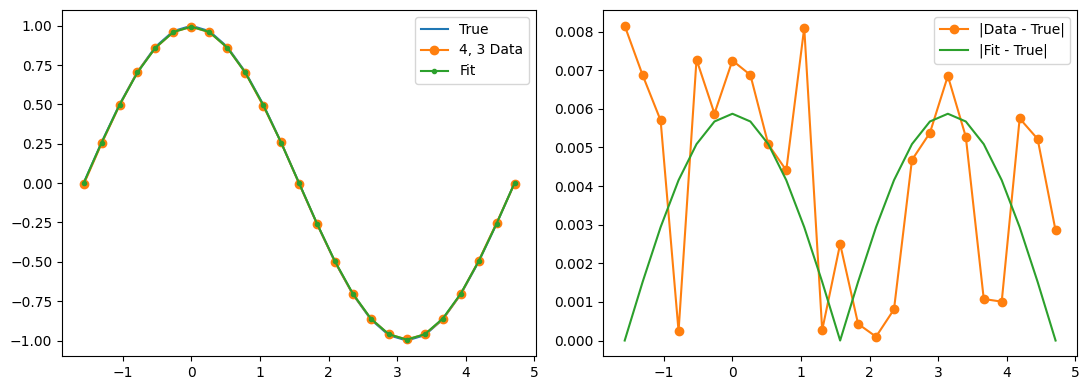

Optimization terminated successfully.
         Current function value: 0.057102
         Iterations: 22
         Function evaluations: 42
Qubit 5, 0
depol   = 0.20%
decay   = 1.21%
readout = 1.13%


In [12]:
# Initial values
depol_prob = 0.01
decay_prob = 0.01
readout_prob = 0.01

opt_results = []
for i, entry in dfb.iterrows():
    ofunc, results = get_obj_func(entry['z_vals'])    
    opt_result = scipy.optimize.minimize(ofunc, 
                                         [depol_prob, decay_prob, readout_prob],
                                         method='nelder-mead',
                                         options={'disp': True})
    label = f"{entry['qubit'].row}, {entry['qubit'].col}"
    print("Qubit", label)
    print_result(opt_result.x)
    opt_results.append(opt_result)
    
    data_expectations = entry['z_vals']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    ax1.plot(thetas, true_z_vals, label='True')
    ax1.plot(thetas, data_expectations, 'o-', label=f'{label} Data')
    ax1.plot(thetas, results[-1], '.-', label='Fit')
    
    ax2.plot([], []) # advance color cycle
    ax2.plot(thetas, np.abs(true_z_vals - data_expectations), 'o-', label='|Data - True|')
    ax2.plot(thetas, np.abs(true_z_vals - results[-1]), '-', label='|Fit - True|')
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    fig.tight_layout()
    plt.show()